In [2]:
import csv
import sys
import time

from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import requests
from lxml import etree
from tqdm.notebook import tqdm
import japanize_matplotlib

from pathlib import Path
cur_dir = Path().resolve()
sys.path.append(str(cur_dir) + "/module")

In [ ]:
# 取得開始年
year_start = 2019
# 取得終了年
year_end = 2022

for year in range(year_start, year_end):
    race_data_all = []
    # 取得するデータのヘッダー情報を先に追加しておく
    race_data_all.append(['race_id','馬','騎手','馬番','走破時間','オッズ','通過順','着順','体重','体重変化','性','齢','斤量','上がり','人気','レース名','日付','開催','クラス','芝・ダート','距離','回り','馬場','天気','場id','場名'])
    List=[]
    #競馬場
    l=["01","02","03","04","05","06","07","08","09","10"]
    for w in range(len(l)):
        place = ""
        if l[w] == "01":
            place = "札幌"
        elif l[w] == "02":
            place = "函館"
        elif l[w] == "03":
            place = "福島"
        elif l[w] == "04":
            place = "新潟"
        elif l[w] == "05":
            place = "東京"
        elif l[w] == "06":
            place = "中山"
        elif l[w] == "07":
            place = "中京"
        elif l[w] == "08":
            place = "京都"
        elif l[w] == "09":
            place = "阪神"
        elif l[w] == "10":
            place = "小倉"

        #開催回数分ループ（6回）
        for z in range(7):
            #開催日数分ループ（12日）
            for y in range(13):
                race_id = ''
                if y<9:
                    race_id = str(year)+l[w]+"0"+str(z+1)+"0"+str(y+1)
                    url1="https://db.netkeiba.com/race/"+race_id
                else:
                    race_id = str(year)+l[w]+"0"+str(z+1)+"0"+str(y+1)
                    url1="https://db.netkeiba.com/race/"+race_id
                #yの更新をbreakするためのカウンター
                yBreakCounter = 0
                #レース数分ループ（12R）
                for x in range(12):
                    if x<9:
                        url=url1+str("0")+str(x+1)
                        current_race_id = race_id+str("0")+str(x+1)
                    else:
                        url=url1+str(x+1)
                        current_race_id = race_id+str(x+1)
                    try:
                        r=requests.get(url)
                    #リクエストを投げすぎるとエラーになることがあるため
                    #失敗したら10秒待機してリトライする
                    except requests.exceptions.RequestException as e:
                        print(f"Error: {e}")
                        print("Retrying in 10 seconds...")
                        time.sleep(10)  # 10秒待機
                        r=requests.get(url)
                    #バグ対策でdecode
                    soup = BeautifulSoup(r.content.decode("euc-jp", "ignore"), "html.parser")
                    soup_span = soup.find_all("span")
                    #馬の数
                    allnum=(len(soup_span)-6)/3
                    #urlにデータがあるか判定
                    if allnum < 1:
                        yBreakCounter+=1
                        print('continue: ' + url)
                        continue
                    allnum=int(allnum)
                    race_data = []
                    for num in range(allnum):
                        #馬の情報
                        soup_txt_l=soup.find_all(class_="txt_l")
                        soup_txt_r=soup.find_all(class_="txt_r")
                        #走破時間
                        runtime=''
                        try:
                            runtime=soup_txt_r[2+5*num].contents[0]
                        except IndexError:
                            runtime = ''
                        soup_nowrap = soup.find_all("td",nowrap="nowrap",class_=None)
                        #通過順
                        pas = ''
                        try:
                            pas = str(soup_nowrap[3*num].contents[0])
                        except:
                            pas = ''
                        weight = 0
                        weight_dif = 0
                        #体重
                        var = soup_nowrap[3*num+1].contents[0]
                        try:
                            weight = int(var.split("(")[0])
                            weight_dif = int(var.split("(")[1][0:-1])
                        except ValueError:
                            weight = 0
                            weight_dif = 0
                        weight = weight
                        weight_dif = weight_dif

                        soup_tet_c = soup.find_all("td",nowrap="nowrap",class_="txt_c")
                        #上がり
                        last = ''
                        try:
                            last = soup_tet_c[6*num+3].contents[0].contents[0]
                        except IndexError:
                            last = ''
                        #人気
                        pop = ''
                        try:
                            pop = soup_span[3*num+10].contents[0]
                        except IndexError:
                            pop = ''
                        
                        #レースの情報
                        try:
                            var = soup_span[8]
                            sur=str(var).split("/")[0].split(">")[1][0]
                            rou=str(var).split("/")[0].split(">")[1][1]
                            dis=str(var).split("/")[0].split(">")[1].split("m")[0][-4:]
                            con=str(var).split("/")[2].split(":")[1][1]
                            wed=str(var).split("/")[1].split(":")[1][1]
                        except IndexError:
                            try:
                                var = soup_span[7]
                                sur=str(var).split("/")[0].split(">")[1][0]
                                rou=str(var).split("/")[0].split(">")[1][1]
                                dis=str(var).split("/")[0].split(">")[1].split("m")[0][-4:]
                                con=str(var).split("/")[2].split(":")[1][1]
                                wed=str(var).split("/")[1].split(":")[1][1]
                            except IndexError:
                                var = soup_span[6]
                                sur=str(var).split("/")[0].split(">")[1][0]
                                rou=str(var).split("/")[0].split(">")[1][1]
                                dis=str(var).split("/")[0].split(">")[1].split("m")[0][-4:]
                                con=str(var).split("/")[2].split(":")[1][1]
                                wed=str(var).split("/")[1].split(":")[1][1]
                        soup_smalltxt = soup.find_all("p",class_="smalltxt")
                        detail=str(soup_smalltxt).split(">")[1].split(" ")[1]
                        date=str(soup_smalltxt).split(">")[1].split(" ")[0]
                        clas=str(soup_smalltxt).split(">")[1].split(" ")[2].replace(u'\xa0', u' ').split(" ")[0]
                        title=str(soup.find_all("h1")[1]).split(">")[1].split("<")[0]

                        race_data = [
                            current_race_id,
                            soup_txt_l[4*num].contents[1].contents[0],#馬の名前
                            soup_txt_l[4*num+1].contents[1].contents[0],#騎手の名前
                            soup_txt_r[1+5*num].contents[0],#馬番
                            runtime,#走破時間
                            soup_txt_r[3+5*num].contents[0],#オッズ,
                            pas,#通過順
                            num+1,#着順
                            weight,#体重
                            weight_dif,#体重変化
                            soup_tet_c[6*num].contents[0][0],#性
                            soup_tet_c[6*num].contents[0][1],#齢
                            soup_tet_c[6*num+1].contents[0],#斤量
                            last,#上がり
                            pop,#人気,
                            title,#レース名
                            date,#日付
                            detail,
                            clas,#クラス
                            sur,#芝かダートか
                            dis,#距離
                            rou,#回り
                            con,#馬場状態
                            wed,#天気
                            w,#場
                            place]
                        race_data_all.append(race_data)
                    
                    print(detail+str(x+1)+"R")#進捗を表示
                    
                if yBreakCounter == 12:#12レース全部ない日が検出されたら、その開催中の最後の開催日と考える
                    break
    #1年毎に出力
    #出力先とファイル名は修正してください
    with open('data/'+str(year)+'.csv', 'w', newline='',encoding="SHIFT-JIS") as f:
        csv.writer(f).writerows(race_data_all)
    print("終了")

In [24]:
year_start = 2019   # 取得開始年
year_end = 2022 # 取得終了年

year = 2020
race_data_all = []
# 取得するデータのヘッダー情報を先に追加しておく
race_data_all.append(['race_id','Horse','Jockey','HorseNo','GoalTime','Odds','PassingOrder','OrderofArrival','Weight','WeightChange','Sex','Age','Charge','Last3F','Popular','RaceName','Date','Stage','Class','Turf/Dirt','Distance','Direction','TurfState','Weather','FieldID','Field'])
List=[]
# 競馬場
l=["01","02","03","04","05","06","07","08","09","10"]
# for w in range(len(l)):
w = 5
place = ""
if l[w] == "01":
    place = "札幌"
elif l[w] == "02":
    place = "函館"
elif l[w] == "03":
    place = "福島"
elif l[w] == "04":
    place = "新潟"
elif l[w] == "05":
    place = "東京"
elif l[w] == "06":
    place = "中山"
elif l[w] == "07":
    place = "中京"
elif l[w] == "08":
    place = "京都"
elif l[w] == "09":
    place = "阪神"
elif l[w] == "10":
    place = "小倉"

#開催回数分ループ（6回）
for z in range(7):
    #開催日数分ループ（12日）
    for y in range(13):
        race_id = ''
        if y<9:
            race_id = str(year)+l[w]+"0"+str(z+1)+"0"+str(y+1)
            url1="https://db.netkeiba.com/race/"+race_id
        else:
            race_id = str(year)+l[w]+"0"+str(z+1)+"0"+str(y+1)
            url1="https://db.netkeiba.com/race/"+race_id
        #yの更新をbreakするためのカウンター
        yBreakCounter = 0
        #レース数分ループ（12R）
        for x in range(12):
            if x<9:
                url=url1+str("0")+str(x+1)
                current_race_id = race_id+str("0")+str(x+1)
            else:
                url=url1+str(x+1)
                current_race_id = race_id+str(x+1)
            try:
                r=requests.get(url)
            #リクエストを投げすぎるとエラーになることがあるため
            #失敗したら10秒待機してリトライする
            except requests.exceptions.RequestException as e:
                print(f"Error: {e}")
                print("Retrying in 10 seconds...")
                time.sleep(10)  # 10秒待機
                r=requests.get(url)
            #バグ対策でdecode
            soup = BeautifulSoup(r.content.decode("euc-jp", "ignore"), "html.parser")
            soup_span = soup.find_all("span")
            #馬の数
            allnum=(len(soup_span)-6)/3
            #urlにデータがあるか判定
            if allnum < 1:
                yBreakCounter+=1
                print('continue: ' + url)
                continue
            allnum=int(allnum)
            race_data = []
            for num in range(allnum):
                #馬の情報
                soup_txt_l=soup.find_all(class_="txt_l")
                soup_txt_r=soup.find_all(class_="txt_r")
                #走破時間
                runtime=''
                try:
                    runtime=soup_txt_r[2+5*num].contents[0]
                except IndexError:
                    runtime = ''
                soup_nowrap = soup.find_all("td",nowrap="nowrap",class_=None)
                #通過順
                pas = ''
                try:
                    pas = str(soup_nowrap[3*num].contents[0])
                except:
                    pas = ''
                weight = 0
                weight_dif = 0
                #体重
                var = soup_nowrap[3*num+1].contents[0]
                try:
                    weight = int(var.split("(")[0])
                    weight_dif = int(var.split("(")[1][0:-1])
                except ValueError:
                    weight = 0
                    weight_dif = 0
                weight = weight
                weight_dif = weight_dif

                soup_tet_c = soup.find_all("td",nowrap="nowrap",class_="txt_c")
                #上がり
                last = ''
                try:
                    last = soup_tet_c[6*num+3].contents[0].contents[0]
                except IndexError:
                    last = ''
                #人気
                pop = ''
                try:
                    pop = soup_span[3*num+10].contents[0]
                except IndexError:
                    pop = ''
                
                #レースの情報
                try:
                    var = soup_span[8]
                    sur=str(var).split("/")[0].split(">")[1][0]
                    rou=str(var).split("/")[0].split(">")[1][1]
                    dis=str(var).split("/")[0].split(">")[1].split("m")[0][-4:]
                    con=str(var).split("/")[2].split(":")[1][1]
                    wed=str(var).split("/")[1].split(":")[1][1]
                except IndexError:
                    try:
                        var = soup_span[7]
                        sur=str(var).split("/")[0].split(">")[1][0]
                        rou=str(var).split("/")[0].split(">")[1][1]
                        dis=str(var).split("/")[0].split(">")[1].split("m")[0][-4:]
                        con=str(var).split("/")[2].split(":")[1][1]
                        wed=str(var).split("/")[1].split(":")[1][1]
                    except IndexError:
                        var = soup_span[6]
                        sur=str(var).split("/")[0].split(">")[1][0]
                        rou=str(var).split("/")[0].split(">")[1][1]
                        dis=str(var).split("/")[0].split(">")[1].split("m")[0][-4:]
                        con=str(var).split("/")[2].split(":")[1][1]
                        wed=str(var).split("/")[1].split(":")[1][1]
                soup_smalltxt = soup.find_all("p",class_="smalltxt")
                detail=str(soup_smalltxt).split(">")[1].split(" ")[1]
                date=str(soup_smalltxt).split(">")[1].split(" ")[0]
                clas=str(soup_smalltxt).split(">")[1].split(" ")[2].replace(u'\xa0', u' ').split(" ")[0]
                title=str(soup.find_all("h1")[1]).split(">")[1].split("<")[0]

                race_data = [
                    current_race_id,
                    soup_txt_l[4*num].contents[1].contents[0],#馬の名前
                    soup_txt_l[4*num+1].contents[1].contents[0],#騎手の名前
                    soup_txt_r[1+5*num].contents[0],#馬番
                    runtime,#走破時間
                    soup_txt_r[3+5*num].contents[0],#オッズ,
                    pas,#通過順
                    num+1,#着順
                    weight,#体重
                    weight_dif,#体重変化
                    soup_tet_c[6*num].contents[0][0],#性
                    soup_tet_c[6*num].contents[0][1],#齢
                    soup_tet_c[6*num+1].contents[0],#斤量
                    last,#上がり
                    pop,#人気,
                    title,#レース名
                    date,#日付
                    detail,
                    clas,#クラス
                    sur,#芝かダートか
                    dis,#距離
                    rou,#回り
                    con,#馬場状態
                    wed,#天気
                    w,#場
                    place]
                race_data_all.append(race_data)
            
            print(detail+str(x+1)+"R")#進捗を表示
            
        if yBreakCounter == 12:#12レース全部ない日が検出されたら、その開催中の最後の開催日と考える
            break
    #1年毎に出力
    #出力先とファイル名は修正してください
    with open('data/'+str(year)+'.csv', 'w', newline='',encoding="SHIFT-JIS") as f:
        csv.writer(f).writerows(race_data_all)
    print("終了")

1回中山1日目1R
1回中山1日目2R
1回中山1日目3R
1回中山1日目4R
1回中山1日目5R
1回中山1日目6R
1回中山1日目7R
1回中山1日目8R
1回中山1日目9R
1回中山1日目10R
1回中山1日目11R
1回中山1日目12R
1回中山2日目1R
1回中山2日目2R
1回中山2日目3R
1回中山2日目4R
1回中山2日目5R
1回中山2日目6R
1回中山2日目7R
1回中山2日目8R
1回中山2日目9R
1回中山2日目10R
1回中山2日目11R
1回中山2日目12R
1回中山3日目1R
1回中山3日目2R
1回中山3日目3R
1回中山3日目4R
1回中山3日目5R
1回中山3日目6R
1回中山3日目7R
1回中山3日目8R
1回中山3日目9R
1回中山3日目10R
1回中山3日目11R
1回中山3日目12R
1回中山4日目1R
1回中山4日目2R
1回中山4日目3R
1回中山4日目4R
1回中山4日目5R
1回中山4日目6R
1回中山4日目7R
1回中山4日目8R
1回中山4日目9R
1回中山4日目10R
1回中山4日目11R
1回中山4日目12R
1回中山5日目1R
1回中山5日目2R
1回中山5日目3R
1回中山5日目4R
1回中山5日目5R
1回中山5日目6R
1回中山5日目7R
1回中山5日目8R
1回中山5日目9R
1回中山5日目10R
1回中山5日目11R
1回中山5日目12R
1回中山6日目1R
1回中山6日目2R
1回中山6日目3R
1回中山6日目4R
1回中山6日目5R
1回中山6日目6R
1回中山6日目7R
1回中山6日目8R
1回中山6日目9R
1回中山6日目10R
1回中山6日目11R
1回中山6日目12R
1回中山7日目1R
1回中山7日目2R
1回中山7日目3R
1回中山7日目4R
1回中山7日目5R
1回中山7日目6R
1回中山7日目7R
1回中山7日目8R
1回中山7日目9R
1回中山7日目10R
1回中山7日目11R
1回中山7日目12R
1回中山8日目1R
1回中山8日目2R
1回中山8日目3R
1回中山8日目4R
1回中山8日目5R
1回中山8日目6R
1回中山8日目7R
1回中山8日目8R
1回中山8日目9R
1回中山8日目10R
1回中山8日目11R
1回中山8日目12R
1回中山9日目1R
1回中山9日

In [3]:
df20 = pd.read_csv('data/2020.csv', index_col=0, encoding='SHIFT-JIS')
df21 = pd.read_csv('data/2021.csv', index_col=0, encoding='SHIFT-JIS')
df22 = pd.read_csv('data/2022.csv', index_col=0, encoding='SHIFT-JIS')

In [4]:
horse_list = [horse for horse in df20['馬']]

In [6]:
df_nakayama = pd.concat([df20, df21, df22])
# df_nakayama.to_csv('data/nakayma_all_2020_2022.csv', index=False, encoding='SHIFT-JIS')

In [7]:
# df = df_nakayama[(df_nakayama['芝・ダート'] == '芝') & (df_nakayama['距離'] == 1800) & (df_nakayama['クラス'] == '3歳以上3勝クラス')]
df = df_nakayama[(df_nakayama['芝・ダート'] == '芝') & (df_nakayama['距離'] == 1800)]

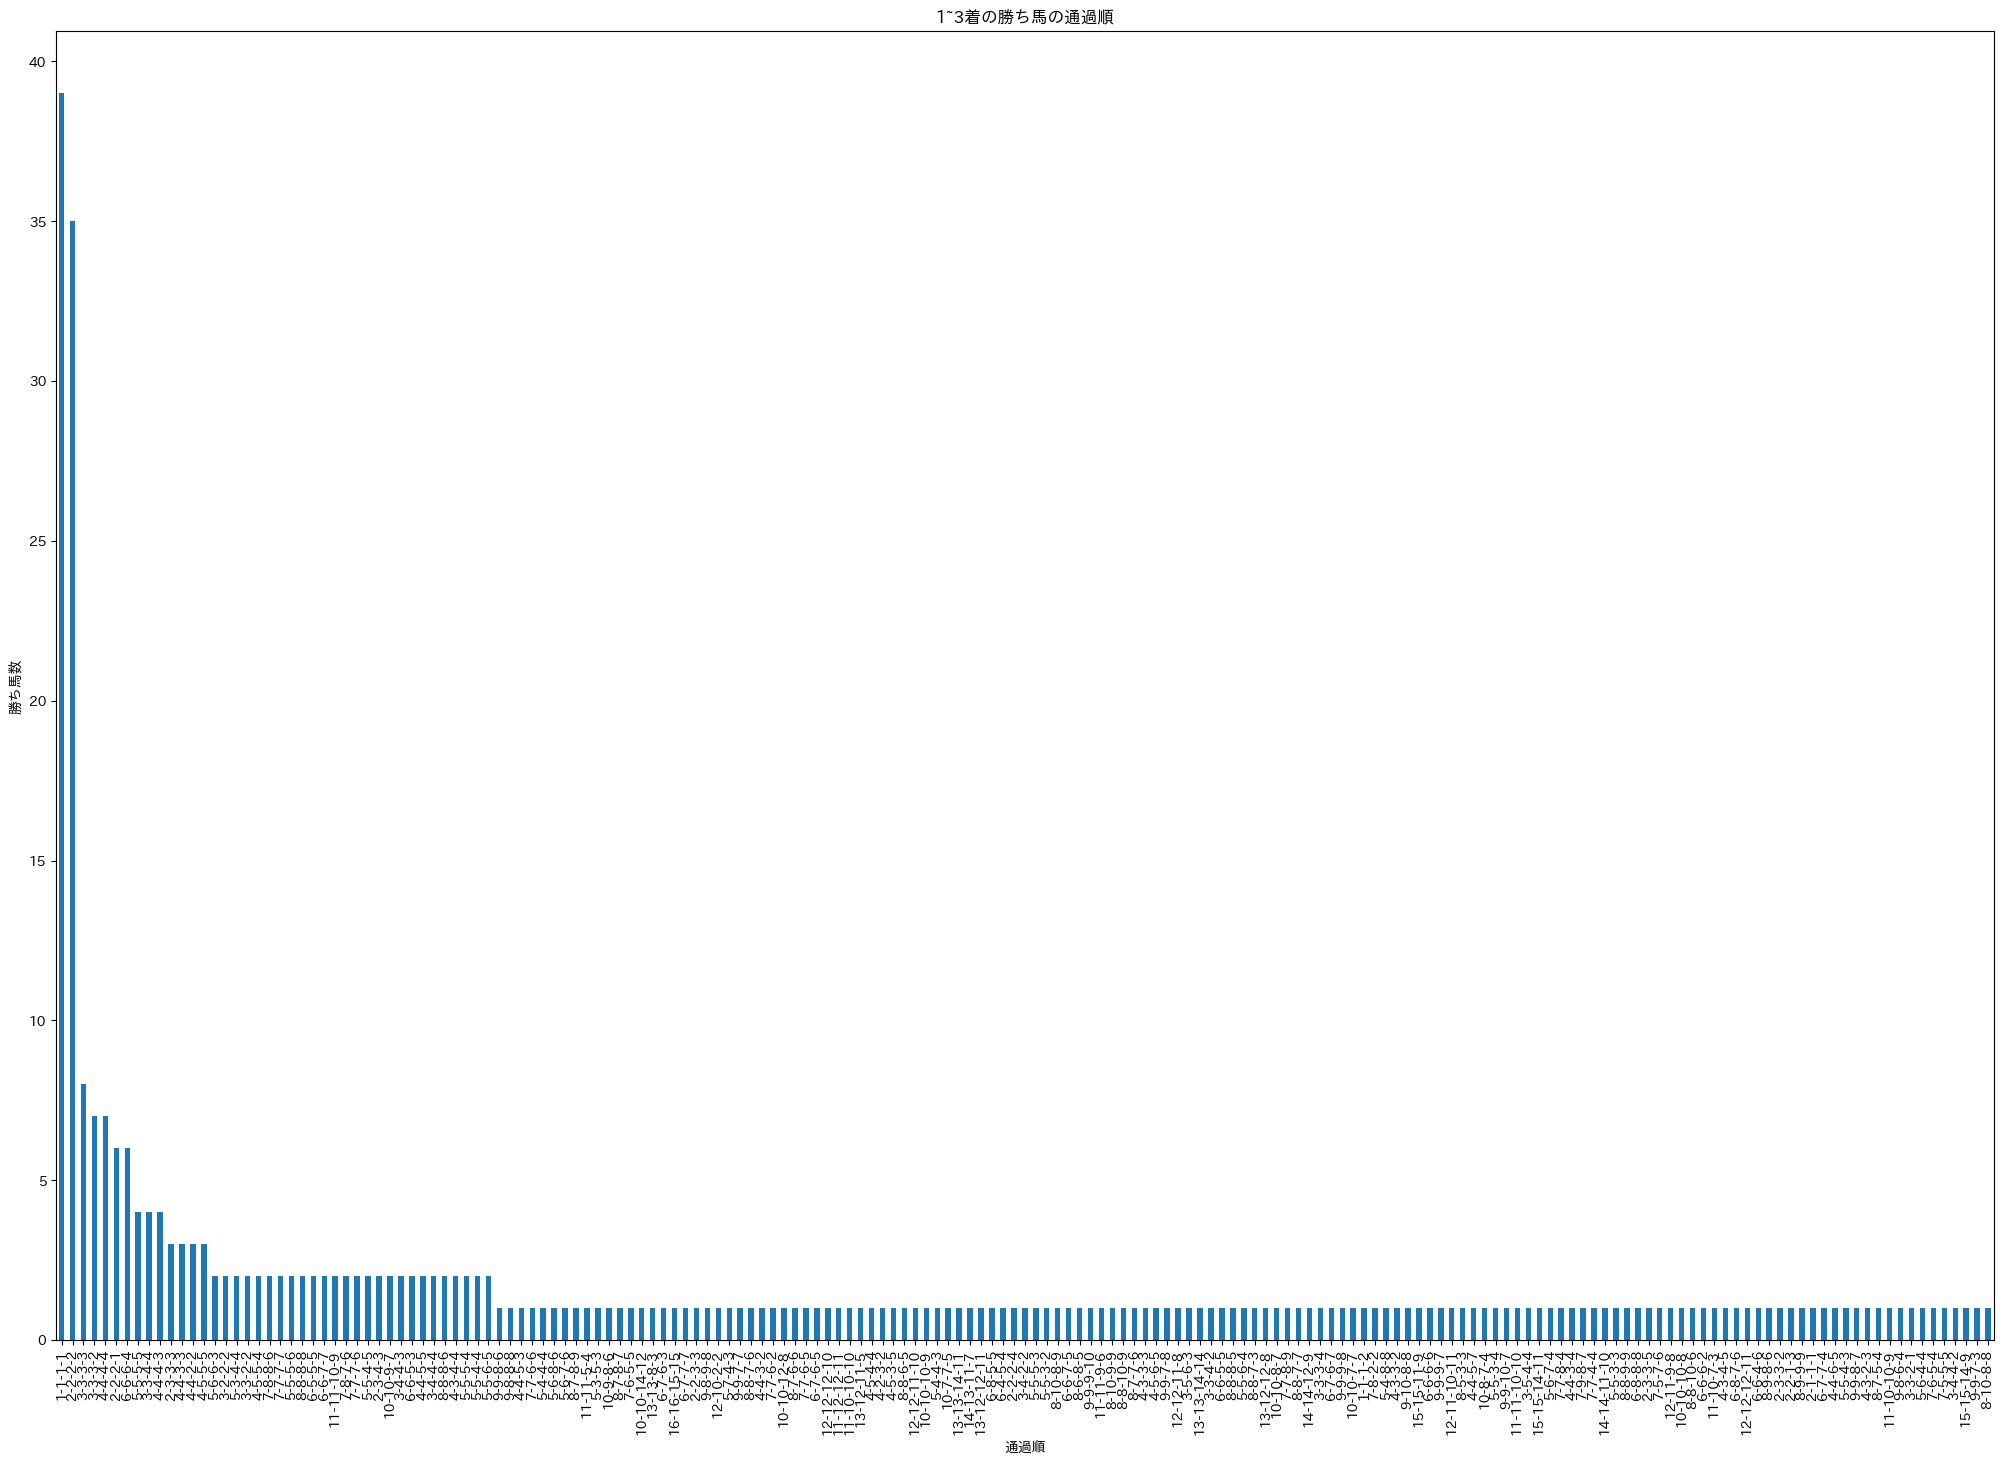

In [11]:
# 1~3着の勝ち馬のデータを抽出
top_3_finishers = df[df['着順'].isin([1, 2, 3])]

# 通過順を集計
passing_order_counts = top_3_finishers['通過順'].value_counts()

# グラフに表示
fig, ax =plt.subplots(figsize=(25, 17))
passing_order_counts.plot(kind='bar')
ax.set_xlabel('通過順')
ax.set_ylabel('勝ち馬数')
ax.set_title('1~3着の勝ち馬の通過順')
plt.show()

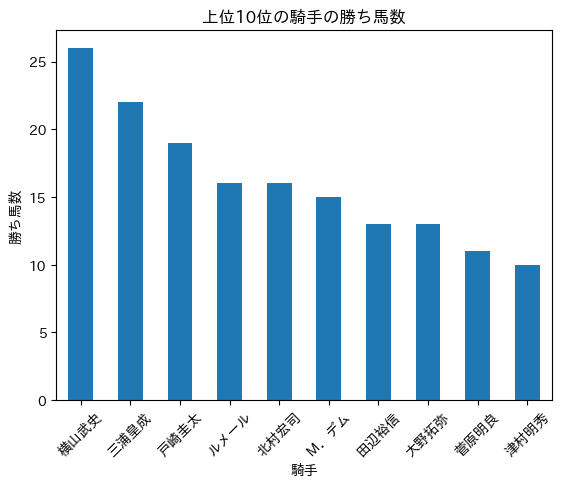

In [15]:
# 1~3着の勝ち馬のデータを抽出
top_3_finishers = df[df['着順'].isin([1, 2, 3])]

# 騎手ごとの勝ち馬数を集計
jockey_wins = top_3_finishers['騎手'].value_counts()

# 上位N位の騎手を選択（例: 上位10位まで）
top_n_jockeys = jockey_wins.head(10)

# グラフに表示
top_n_jockeys.plot(kind='bar')
plt.xlabel('騎手')
plt.ylabel('勝ち馬数')
plt.title('上位10位の騎手の勝ち馬数')
plt.xticks(rotation=45)  # x軸のラベルを回転して表示
plt.show()

c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\Users\kaito\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


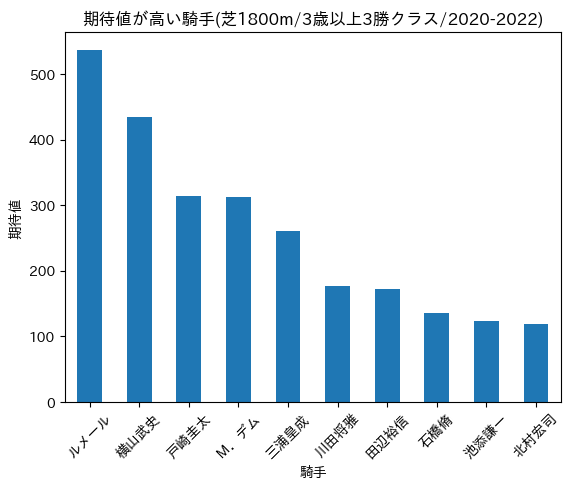

In [16]:
# "オッズ"列のデータ型が文字列 (string) であることを確認
if df['オッズ'].dtype == 'object':
    # オッズ列をクリーニングし、数値に変換
    df['オッズ'] = df['オッズ'].str.replace(',', '', regex=True)  # カンマを削除
    df['オッズ'] = df['オッズ'].str.extract(r'(\d+\.\d+)').astype(float)  # 数値に変換

# 1~3着の勝ち馬のデータを抽出
top_3_finishers = df[df['着順'].isin([1, 2, 3])]

# 各騎手の勝利回数を計算
jockey_wins = top_3_finishers['騎手'].value_counts()

# 各騎手の平均オッズを計算
jockey_avg_odds = top_3_finishers.groupby('騎手')['オッズ'].mean()

# 期待値を計算（期待値 = 勝利回数 / 平均オッズ）
jockey_expected_value = jockey_wins / jockey_avg_odds * 100

# 期待値を降順にソートして上位N位の騎手を選択（ここでは上位10位まで）
top_n_jockeys = jockey_expected_value.sort_values(ascending=False).head(10)

# グラフに表示
top_n_jockeys.plot(kind='bar')
plt.xlabel('騎手')
plt.ylabel('期待値')
plt.title('期待値が高い騎手(芝1800m/3歳以上3勝クラス/2020-2022)')
plt.xticks(rotation=45)  # x軸のラベルを回転して表示
plt.show()

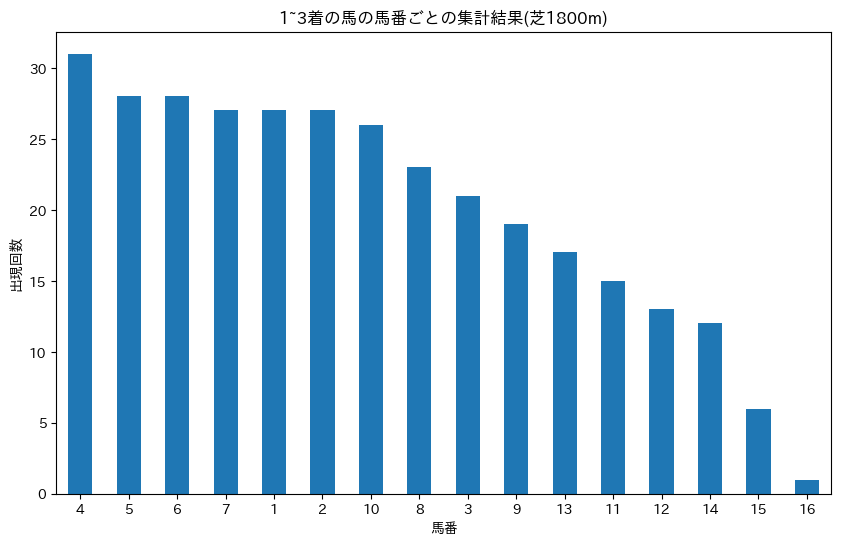

In [17]:
# 着順が1~3の馬のデータを抽出
top_3_finishers = df[df['着順'].isin([1, 2, 3])]

# 馬番ごとの集計を行う
horse_number_counts = top_3_finishers['馬番'].value_counts()

# 集計結果を多い順に並べる
sorted_horse_number_counts = horse_number_counts.sort_values(ascending=False)

# グラフに表示
plt.figure(figsize=(10, 6))  # グラフのサイズを調整（任意のサイズに変更可能）
sorted_horse_number_counts.plot(kind='bar')
plt.xlabel('馬番')
plt.ylabel('出現回数')
plt.title('1~3着の馬の馬番ごとの集計結果(芝1800m)')
plt.xticks(rotation=0)  # x軸のラベルを水平に表示
plt.show()